In [1]:
#IMPORT PACKAGES
from rdflib import Graph
import rdflib
import os.path
import importlib
from pathlib import Path
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
from ifcopenshell.util.selector import Selector
import multiprocessing
import random as rd
import pandas as pd
# from tabulate import tabulate
import cv2
import laspy
import json
from scipy.spatial.transform import Rotation   
import copy
import geomapi
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import geomapi.tools.progresstools as pt

from sklearn.cluster import DBSCAN
from PIL import Image


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## INPUTS

In [4]:
name='rooms'

path=Path(os.getcwd()).parents[2]/'data'
pcd_input_path=os.path.join(path,f'{name}_labels.laz')
class_file=path/'_classes.json'

# name=name.split('_')[0]
# json_output_path=os.path.join(path,f'{name}_walls.json') 
# geometry_output_path= os.path.join(path,f'{name}_walls.obj') # these are the bounding surfaces of the reference levels (optional)
output_dir = "C:\Data\temp"

graphPath=str(path/f'{name}Graph.ttl')

grid_resolution = 0.01

Import Classes

In [5]:
# Read the JSON file
with open(class_file, 'r') as file:
    json_data = json.load(file)

# Create a dictionary
class_dict = {
    'classes': json_data['classes'],
    'default': json_data['default'],
    'type': json_data['type'],
    'format': json_data['format'],
    'created_with': json_data['created_with']
}
print(class_dict)

{'classes': [{'name': 'Unassigned', 'id': 255, 'temp_id': 0, 'color': '#9da2ab'}, {'name': 'Floors', 'id': 0, 'temp_id': 1, 'color': '#03c2fc'}, {'name': 'Ceilings', 'id': 1, 'temp_id': 2, 'color': '#e81416'}, {'name': 'Walls', 'id': 2, 'temp_id': 3, 'color': '#ffa500'}, {'name': 'Columns', 'id': 3, 'temp_id': 4, 'color': '#faeb36'}, {'name': 'Doors', 'id': 4, 'temp_id': 5, 'color': '#79c314'}, {'name': 'Windows', 'id': 5, 'temp_id': 6, 'color': '#4b369d'}], 'default': 255, 'type': 'semantic_segmentation', 'format': 'kitti', 'created_with': {'name': 'Saiga', 'version': '1.0.1'}}


Import Graph

In [6]:
graph=Graph().parse(graphPath)
nodes=tl.graph_to_nodes(graph)
wallBIMNodes=[n for n in nodes if 'Walls' in n.subject and type(n)==BIMNode]
wallPCDNodes=[n for n in nodes if 'Walls' in n.subject and type(n)==PointCloudNode]
ceilingsNodes=[n for n in nodes if 'Ceilings' in n.subject and type(n)==PointCloudNode]
floorsNodes=[n for n in nodes if 'Floors' in n.subject and type(n)==PointCloudNode]
clutterNodes=[n for n in nodes if 'Clutter' in n.subject and type(n)==PointCloudNode]
print(f'{len(wallBIMNodes)} wallNodes detected!')
print(f'{len(wallPCDNodes)} wallNodes detected!')
print(f'{len(ceilingsNodes)} ceilingsNodes detected!')
print(f'{len(floorsNodes)} floorsNodes detected!')
print(f'{len(clutterNodes)} clutterNodes detected!')

28 wallNodes detected!
28 wallNodes detected!
7 ceilingsNodes detected!
9 floorsNodes detected!
1 clutterNodes detected!


In [7]:
print({key:value for key, value in wallBIMNodes[1].__dict__.items() if not key.startswith('__') and not callable(key)})

{'_ifcPath': None, '_globalId': None, '_cartesianBounds': array([-13.47042812,  -9.36387843, -17.70681933, -17.00778565,
         2.43      ,   4.84      ]), '_orientedBounds': array([[-13.47042812, -17.49642414,   2.43      ],
       [ -9.38906787, -17.00778565,   2.43      ],
       [-13.47042812, -17.49642414,   4.84      ],
       [-13.44523868, -17.70681933,   2.43      ],
       [ -9.36387843, -17.21818084,   4.84      ],
       [-13.44523868, -17.70681933,   4.84      ],
       [ -9.36387843, -17.21818084,   2.43      ],
       [ -9.38906787, -17.00778565,   4.84      ]]), '_orientedBoundingBox': None, '_subject': rdflib.term.URIRef('file:///2_Walls_18_BIM'), '_graph': <Graph identifier=N6591cd371c5e452099b3ecc17e458a1d (<class 'rdflib.graph.Graph'>)>, '_graphPath': None, '_path': None, '_name': None, '_timestamp': None, '_resource': None, '_cartesianTransform': array([[  1.        ,   0.        ,   0.        , -11.41715327],
       [  0.        ,   1.        ,   0.        , -17

Import PCD

In [8]:
laz=laspy.read(pcd_input_path)

match point clouds with graph

In [9]:
for n in clutterNodes:#+ceilingsNodes+floorsNodes: # this is quite slow because you iterate through 2 scalar fields every time
    idx=np.where((laz['classes']==n.class_id) & (laz['objects']==n.object_id))
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(laz.xyz[idx])
    red = laz['red'][idx]
    green = laz['green'][idx]
    blue = laz['blue'][idx]
    #if color is 32 bit, only keep 8 bit color
    if red.max()>255:
        red = laz['red'][idx] >> 8 & 0xFF
        green = laz['green'][idx] >> 8 & 0xFF
        blue = laz['blue'][idx] >> 8 & 0xFF
    # if colorspace is [0-255] -> remap to [0-1]
    if red.max() >1:
        red=red/255
        green=green/255
        blue=blue/255
    pcd.colors=o3d.utility.Vector3dVector(np.vstack((red,green,blue)).transpose())

    n.resource=pcd
    n.get_oriented_bounding_box()
    n.orientedBoundingBox.color=[1,0,0]

In [10]:
for n in wallPCDNodes:#+ceilingsNodes+floorsNodes: # this is quite slow because you iterate through 2 scalar fields every time
    idx=np.where((laz['classes']==n.class_id) & (laz['objects']==n.object_id))
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(laz.xyz[idx])
    pcd.paint_uniform_color([0.5,0.5,0.5])
    
    red = laz['red'][idx]
    green = laz['green'][idx]
    blue = laz['blue'][idx]
    #if color is 32 bit, only keep 8 bit color
    if red.max()>255:
        red = laz['red'][idx] >> 8 & 0xFF
        green = laz['green'][idx] >> 8 & 0xFF
        blue = laz['blue'][idx] >> 8 & 0xFF
    # if colorspace is [0-255] -> remap to [0-1]
    if red.max() >1:
        red=red/255
        green=green/255
        blue=blue/255
    
    pcd.colors=o3d.utility.Vector3dVector(np.column_stack((red, green, blue)))

    n.resource=pcd
    n.get_oriented_bounding_box()
    n.orientedBoundingBox.color=[1,0,0] 

match PointCloudNodes to BIMNodes

In [11]:
for n in wallBIMNodes:
    n.derivedFrom = next(p for p in wallPCDNodes if p.subject.toPython() in [w.derivedFrom for w in wallBIMNodes])

In [12]:
# joined_pcd=gmu.join_geometries([n.resource.paint_uniform_color(ut.literal_to_array(n.color)) for n in wallPCDNodes if n.resource is not None])
# o3d.visualization.draw_geometries([joined_pcd])

Import Reference Levels

In [13]:
levelNodes=[n for n in nodes if 'level' in n.subject]
referenceNodes=[]
for l in levelNodes:
    new_graph=ut.get_subject_graph(graph,levelNodes[0].subject)
    n=SessionNode(graph=new_graph)
    n.get_oriented_bounding_box()
    n.resource=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(n.orientedBoundingBox)
    referenceNodes.append(n) # something is wrong in the tl.graph_to_nodes function
levelNodes=referenceNodes
print(f'{len(levelNodes)} levelNodes detected!')

1 levelNodes detected!


Import ceilings and floors

In [14]:
for n in ceilingsNodes+floorsNodes: # this is quite slow because you iterate through 2 scalar fields every time
    idx=np.where((laz['classes']==n.class_id) & (laz['objects']==n.object_id))
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(laz.xyz[idx])
    n.resource=pcd
    n.get_oriented_bounding_box()
    n.orientedBoundingBox.color=[1,1,0]

## PROCESSING

Convert dtrings from the graph to arrays

In [15]:
for n in wallBIMNodes:
    n.startpoint = np.asarray(n.startpoint[1:-1].split(), dtype=float)
    n.endpoint = np.asarray(n.endpoint[1:-1].split(), dtype=float)
    n.normal = np.asarray(n.normal[1:-1].split(), dtype=float)
    n.height = float(n.height)   

In [16]:
def points_on_line(point1, point2, step_size):
    """
    Generate points on a line between two given points with a specified step size.

    Parameters:
    - point1: The starting point of the line.
    - point2: The ending point of the line.
    - step_size: The step size between consecutive points.

    Returns:
    - points: A list of points on the line.
    """
    # Calculate the direction vector
    direction = point2 - point1

    # Calculate the length of the line segment
    length = np.linalg.norm(direction)

    # Normalize the direction vector
    direction /= length

    # Calculate the number of steps needed
    num_steps = int(length / step_size)

    # Generate points along the line
    points = np.array([point1 + i * step_size * direction for i in range(num_steps + 1)])

    return points


Load the full resolution point cloud for a more accurate result (unlabeled)

In [17]:
laz = laspy.read(r"C:\Users\SamDeGeyter\OneDrive - KU Leuven\2024-05 CVPR scan-to-BIM challenge\data\full_resolution_populierenhof.las")
full_res_point_cloud_o3d = gmu.las_to_pcd(laz)

Convert the full point cloud into a mesh and add it to a raycasting scene

In [18]:

#Cut a part out of the full resolution pointcloud
# joined_pcd = full_res_point_cloud_o3d.crop(expanded_bounding_box)
#Create a messh from this point cloud 
octree=pt.pcd_to_octree(full_res_point_cloud_o3d,10) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh


#Create a identity array containing the color so this can be retrieved afterwards
original_colors=np.asarray(mesh.vertex_colors)
indices=np.asarray(mesh.triangles)[:,0]
triangle_colors=original_colors[indices]
#append black color at the end of the array for the invalid hits
triangle_colors=np.vstack((triangle_colors,np.array([0,0,0])))

# Create raycasting scene
scene = o3d.t.geometry.RaycastingScene()
mesh=o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene.add_triangles(mesh) 

# Calculate the size of each octree node based on octree depth and overall size
def calculate_node_size(octree_depth, octree_size):
    num_voxels_per_dim = 2 ** octree_depth
    voxel_size = octree_size / num_voxels_per_dim
    return voxel_size

# Example usage:
octree_depth = octree.max_depth  # Example value for max_depth
octree_size = octree.size  # Example size of the octree in world units
voxel_size = calculate_node_size(octree_depth, octree_size)


## Method 1: Using the pointcloud and wall data to retrieve potential openings in the walls 
(Can also be used to retrieve wall detailing)

In [19]:
def create_opening_pcds(startpoint, endpoint, height, resolution, direction, scene, offset =0.7, path = None, show = False, min_samples = 5000, eps = 0.2, wallThickness = 0.1, voxel_size = 0.01):
    
    min_z = np.min([endpoint[2], startpoint[2]])
    max_z = min_z + height
    num_z_steps = int(height /resolution)
    z_grid = np.linspace(min_z, max_z, num_z_steps)  # Adjust the number of grid points as needed
    xyz_grid = []
    for z in z_grid:
        start = n.startpoint.copy()
        end =  n.endpoint.copy()
        start[2] = z
        end[2] = z
        xyz_grid.append(points_on_line(start, end, resolution))

    grid = np.asarray(xyz_grid).reshape((-1, 3), order='C') 
    
    openingpcds = []
    # Create Open3D point cloud
    grid_center_pcd = o3d.geometry.PointCloud()
    grid_center_pcd.points = o3d.utility.Vector3dVector(np.asarray(grid))
    grid_center_pcd.paint_uniform_color([1,0,0])

    #In face is the dominant side of the wall
    grid_in = grid + direction*offset
    #out face is the other side of the dominant side
    grid_out = grid - direction*offset

    #create rays for the in side (towards the dominant side
    ori_x = direction[0] * np.ones(len(grid))
    ori_y = direction[1] * np.ones(len(grid))
    ori_z = direction[2] * np.ones(len(grid))
    
    pos_x = grid_in[:,0]
    pos_y = grid_in[:,1]
    pos_z = grid_in[:,2]

    # Stack the calculated values along the third axis to create the grid
    rays_in_values = np.stack((pos_x, pos_y, pos_z, -ori_x, -ori_y, -ori_z), axis=1)
    rays_in_tensor = o3d.core.Tensor(rays_in_values, dtype=o3d.core.Dtype.Float32)

    pos_x = grid_out[:,0]
    pos_y = grid_out[:,1]
    pos_z = grid_out[:,2]

    rays_out_values = np.stack((pos_x, pos_y, pos_z, ori_x, ori_y, ori_z), axis=1)
    rays_out_tensor = o3d.core.Tensor(rays_out_values, dtype=o3d.core.Dtype.Float32)       

    ans_in = scene.cast_rays(rays_in_tensor)
    ans_out = scene.cast_rays(rays_out_tensor)

    hits_in = ans_in['t_hit'].numpy()
    hits_out = ans_out['t_hit'].numpy()

    opening_points = []
    opening_colors = []
    
    colors = np.zeros((len(hits_in), 3))
    for i, c in enumerate(colors):
        if hits_in[i] > 2*offset and hits_out[i] > 2*offset:
            colors[i] = [0,1,0]
            opening_points.append(grid[i])
            opening_colors.append([0,1,0])

        elif hits_in[i] <2*offset or hits_out[i] < 2*offset:
            colors[i] = [0.5,0.5,0.5]
            thickness = 2*offset-hits_out[i]-hits_in[i]
    
            if 1.2*voxel_size < thickness < 0.5*wallThickness:
                # colors[i] = [1,0.5,0]
                opening_points.append(grid[i])
                opening_colors.append([0,1,0])


    # grid_center_pcd.colors =o3d.utility.Vector3dVector(np.asarray(colors))
    opening_pcd = o3d.geometry.PointCloud()
    opening_pcd.points = o3d.utility.Vector3dVector(np.asarray(opening_points))
    opening_pcd.colors = o3d.utility.Vector3dVector(np.asarray(opening_colors))
    
    opening_pcd, ind = opening_pcd.remove_radius_outlier(nb_points = 100, radius = 0.1)

    # o3d.visualization.draw_geometries([opening_pcd])

    points = np.asarray(opening_pcd.points)
    if len(points) > min_samples:

        # Perform clustering using DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(points)

        # Extract unique cluster labels (excluding noise label -1)
        unique_labels = np.unique(labels[labels != -1])

        # Iterate over each cluster label and save corresponding points to a separate point cloud
        for label in unique_labels:
            cluster_points = points[labels == label]
            cluster_pcd = o3d.geometry.PointCloud()
            cluster_pcd.points = o3d.utility.Vector3dVector(cluster_points)
            openingpcds.append(cluster_pcd)
    if show:
        o3d.visualization.draw_geometries(openingpcds)
    # o3d.visualization.draw_geometries([grid_center_pcd])
   
    return openingpcds
    

In [20]:
pcd_resolution = 0.01

for n in wallBIMNodes[20:21]:
    
    length = np.sqrt(np.sum((n.endpoint - n.startpoint)**2))
    surface = length * n.height
    n.openings = []

    if not surface < 3 and n.height > 1.5 and length > 0.8:        
        n.openings1 = create_opening_pcds(startpoint = n.startpoint, endpoint = n.endpoint, height=n.height, resolution= 0.01, direction= n.normal, scene= scene, offset =0.5, path = None, show = False, min_samples = 1000, eps = 0.25, wallThickness = n.wallThickness, voxel_size=voxel_size)
        

In [21]:
def is_door(openingwidth, openingheight, t_min_width = 0.5, t_max_width = 3, t_min_height = 1.5, t_max_height = 2.3):

    if t_min_width < openingwidth < t_max_width and t_min_height < openingheight < t_max_height:
        return True
    else: 
        return False

In [26]:
doors = []
other = []
for n in wallBIMNodes[20:21]:
    n.baseConstraint = next(l for l in levelNodes if l.subject.toPython() in [w.base_constraint for w in wallBIMNodes])
    
    if len(n.openings1) > 0:
        for opening in n.openings1:
            # Extract the z-coordinates
            points2 = np.asarray(opening.points)
            z_values = points2[:, 2]
            unique_z_values = np.unique(z_values)

            #Compute the width of the opening
            opening_width = 0.0
            for z_value in unique_z_values:
                # Get points with the current z-value
                points_with_same_z = points2[z_values == z_value]

                # Find the outermost points based on XY coordinates
                min_x = np.min(points_with_same_z[:, 0])
                max_x = np.max(points_with_same_z[:, 0])
                min_y = np.min(points_with_same_z[:, 1])
                max_y = np.max(points_with_same_z[:, 1])

                # Compute the diagonal length of the bounding box
                diagonal_length = np.linalg.norm([max_x - min_x, max_y - min_y])

                if diagonal_length > opening_width:
                    opening_width = diagonal_length
                    
            print("Opening Width:", opening_width)
            
            #Compute the Height of the door
            lowest_z = np.min(z_values)
            highest_z = np.max(z_values)
            opening_height = highest_z - lowest_z   
            print("Opening height:", opening_height)
            
            if is_door(openingwidth = opening_width, openingheight = opening_height, t_min_width = 0.5, t_max_width = 3, t_min_height = 1.5, t_max_height = 2.3):
                doors.append(opening)
                print("This is most likely a door")

Opening Width: 0.9300000000000004
Opening height: 2.0677443609022563
This is most likely a door
Opening Width: 0.9300000000000002
Opening height: 2.0677443609022563
This is most likely a door
Opening Width: 0.9199999999999989
Opening height: 2.0677443609022563
This is most likely a door
Opening Width: 1.2899999999999998
Opening height: 1.1844360902255646
Opening Width: 4.799999999999999
Opening height: 0.26097744360902286
Opening Width: 2.389999999999999
Opening height: 0.2509398496240598


In [27]:
o3d.visualization.draw_geometries(doors)

## Method 2: Using the pointcloud and wall data to create an ortho foto of the wall and use object detection
(Can also be used to retrieve other elements)

In [74]:
def create_wall_ortho(startpoint, endpoint, height, resolution, direction, scene, offset =0.7, path = None, show = False, dominant = True):
    image_size = (int(np.sqrt(np.sum((endpoint - startpoint)**2)) / resolution)+1, int(height / resolution))
    
    min_z = np.min([endpoint[2], startpoint[2]])
    max_z = min_z + height
    num_z_steps = int(height /resolution)
    z_grid = np.linspace(min_z, max_z, num_z_steps)  # Adjust the number of grid points as needed
    z_grid = z_grid[::-1]
    xyz_grid = []
    for z in z_grid:
        start = startpoint.copy()
        end =  endpoint.copy()
        start[2] = z
        end[2] = z
        if not dominant:
            xyz_grid.append(points_on_line(start, end, resolution)[::-1])
        else: 
            xyz_grid.append(points_on_line(start, end, resolution))

    grid = np.asarray(xyz_grid).reshape((-1, 3), order='C') 
    ray_grid = grid + direction*offset
    
    #create rays for the in side (towards the dominant side
    ori_x = direction[0] * np.ones(len(ray_grid))
    ori_y = direction[1] * np.ones(len(ray_grid))
    ori_z = direction[2] * np.ones(len(ray_grid))
    
    pos_x = ray_grid[:,0]
    pos_y = ray_grid[:,1]
    pos_z = ray_grid[:,2]
    
    # Stack the calculated values along the third axis to create the grid
    rays_values = np.stack((pos_x, pos_y, pos_z, -ori_x, -ori_y, -ori_z), axis=1)
    rays_tensor = o3d.core.Tensor(rays_values, dtype=o3d.core.Dtype.Float32)
    
    ans= scene.cast_rays(rays_tensor) 
    
    triangle_ids = ans["primitive_ids"].numpy() # triangles     
    triangle_ids = triangle_ids.flatten()
    np.put(triangle_ids,np.where(triangle_ids==scene.INVALID_ID),triangle_colors.shape[0]-1) # replace invalid id's by last (which is the above added black color)
    
    colors = triangle_colors[triangle_ids]
    ortho = np.reshape(colors,(image_size[1],image_size[0],3))
    if show:
        plt.imshow(ortho)
        plt.show()
    if path: 
        image = Image.fromarray((ortho * 255).astype(np.uint8))
        # Save the image
        image.save(path)
        
    return ortho

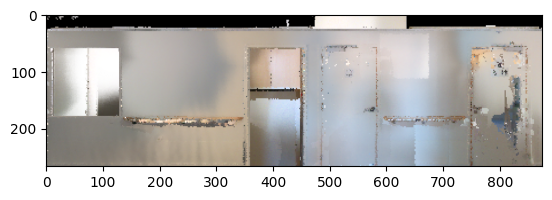

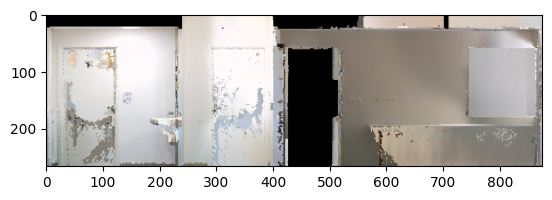

In [75]:
image_resolution = 0.01

for n in wallBIMNodes[20:21]:
    
    length = np.sqrt(np.sum((n.endpoint - n.startpoint)**2))
    surface = length * n.height
    image_size = (int(length / image_resolution), int(n.height / image_resolution))
    n.openings = []

    if not surface < 3 and n.height > 1.5 and length > 0.8:  
        #Create an ortho of the dominant side of the wall      
        name = 'test.png'
        ortho = create_wall_ortho(startpoint = n.startpoint, endpoint= n.endpoint, height= n.height, resolution = image_resolution, direction = n.normal, scene=scene, path = os.path.join(r"C:\Data\temp", name), show = True)
        #Also create an ortho of the other side of the wall
        name = 'test2.png'
        ortho = create_wall_ortho(startpoint = n.startpoint, endpoint= n.endpoint, height= n.height, resolution = image_resolution, direction = -n.normal, scene=scene, path = os.path.join(r"C:\Data\temp", name), show = True, dominant = False)

In [4]:
import os, sys

# sys.path.append(os.path.join(os.getcwd(), "thirdparty\groundingdino"))

# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import os

import numpy as np
import torch
from PIL import Image
from torchvision.ops import box_convert

# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
# from segment_anything import build_sam, SamPredictor 
import numpy as np


# diffusers
import torch

from huggingface_hub import hf_hub_download

In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [6]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [7]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device="cuda")

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Model loaded from /home/sdegeyter/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


2024-04-11 16:13:37.019901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:13:38.308850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sdegeyter/.conda/envs/pointcept/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-11 16:13:38.308960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sdegeyter/.conda/envs/pointcept/lib/pyth

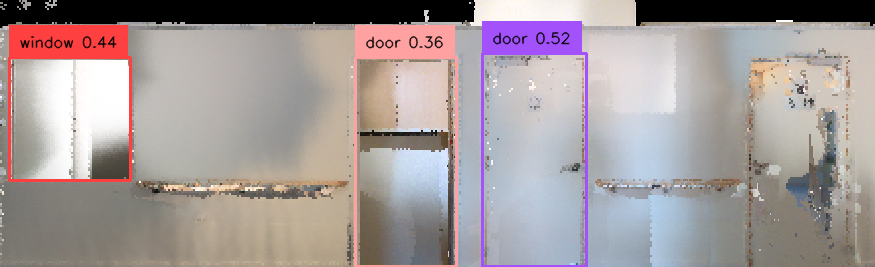

In [10]:
TEXT_PROMPT = "Door . Window"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.3

image_source, image = load_image('../data/test.png')

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

Image.fromarray(annotated_frame)